In [13]:
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import numpy as np

In [7]:
import sys
from pathlib import Path
file = Path(__file__).resolve()
package_root_directory = file.parents[1]
sys.path.append(str(package_root_directory))

NameError: name '__file__' is not defined

In [14]:
f0 = 1
learning_rate = 0.01
training_steps = 200
batch_size = 100
display_step = 20 # Network Parameters

# Stochastic gradient descent optimizer.
optimizer = tf.optimizers.SGD(learning_rate)

## Create the model

In [15]:
# méthode API Sequential
multilayer_perceptron = keras.models.Sequential([
  keras.layers.Input(shape=[1],name='input layer'),
  keras.layers.GaussianNoise(stddev=1e-3),
  keras.layers.Dense(10,activation='selu'),
  keras.layers.Dense(10,activation='selu'),
  keras.layers.Dense(1)
])

In [11]:
# Méthode à développer : API Subclassing
# Voir https://www.tensorflow.org/guide/keras/custom_layers_and_models

class PINN (keras.Model): 
    # Physics-informed neural network, très simple pour l'instant

    def __init__(self,units=30,activation='relu',**kwargs):  
        super().__init__(**kwargs) #gère les arguments standard (ex : name)
        self.noise = keras.layers.GaussianNoise(stddev=0) # à modifier pour voir
        self.hidden1 = keras.layers.Dense(units, activation = activation)
        self.hidden2 = keras.layers.Dense(units, activation = activation)
        self.main_output = keras.layers.Dense(1)
    
    def call(self, inputs):
        noise = self.noise(inputs)
        hidden1 = self.hidden1(noise)
        hidden2 = self.hidden2(hidden1)
        main_output = self.main_output(hidden2)
        return main_output

multilayer_perceptron = PINN(units=10,name="model d'API Subclassing pour PINN")

In [16]:
# Universal Approximator
def g(x):
  return x *multilayer_perceptron(x)  + f0

# Given EDO
def f(x):
  return 2*x

def differentiate(model,x):
  with tf.GradientTape(persistent=True) as tape:
    tape.watch(x)
    # print(x)
    u = model(tf.reshape(x,[1])) # sans la reshape a une shape () invalide pour model
  du_dx = tape.gradient(u,x) 
  return du_dx


# Custom loss function to approximate the derivatives
def custom_loss():
  summation = []
  for x in tf.constant(np.linspace(-1,1,10),dtype='float32'):  # in mesh
    dNN = differentiate(g,x)
    summation.append((dNN - f(x))**2)
  return tf.sqrt(tf.reduce_mean(tf.abs(summation)))

## Train the model

In [17]:
def train_step():
  with tf.GradientTape() as tape:
      loss = custom_loss()
  trainable_variables=multilayer_perceptron.trainable_variables
  gradients = tape.gradient(loss, trainable_variables)
  optimizer.apply_gradients(zip(gradients, trainable_variables))

# Training the Model:

for i in range(training_steps):
  print ('epoch:',i)
  train_step()
  if i % display_step == 0:
    print("loss: %f " % (custom_loss()))

epoch: 0
loss: 1.778880 
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
epoch: 10
epoch: 11
epoch: 12
epoch: 13
epoch: 14
epoch: 15
epoch: 16
epoch: 17
epoch: 18
epoch: 19
epoch: 20
loss: 0.125799 
epoch: 21
epoch: 22
epoch: 23
epoch: 24
epoch: 25
epoch: 26
epoch: 27
epoch: 28
epoch: 29
epoch: 30
epoch: 31
epoch: 32
epoch: 33
epoch: 34
epoch: 35
epoch: 36
epoch: 37
epoch: 38
epoch: 39
epoch: 40
loss: 0.111445 
epoch: 41
epoch: 42
epoch: 43
epoch: 44
epoch: 45
epoch: 46
epoch: 47
epoch: 48
epoch: 49
epoch: 50
epoch: 51
epoch: 52
epoch: 53
epoch: 54
epoch: 55
epoch: 56
epoch: 57
epoch: 58
epoch: 59
epoch: 60
loss: 0.096466 
epoch: 61
epoch: 62
epoch: 63
epoch: 64
epoch: 65
epoch: 66
epoch: 67
epoch: 68
epoch: 69
epoch: 70
epoch: 71
epoch: 72
epoch: 73
epoch: 74
epoch: 75
epoch: 76
epoch: 77
epoch: 78
epoch: 79
epoch: 80
loss: 0.079822 
epoch: 81
epoch: 82
epoch: 83
epoch: 84
epoch: 85
epoch: 86
epoch: 87
epoch: 88
epoch: 89
epoch: 90
epoch: 91
epoch: 92


## Save the model

In [23]:
multilayer_perceptron.save('my_keras_model_0.h5')

In [ ]:
# API Subclassing
multilayer_perceptron.save_weights('weights_API_Subclassing_model')

## Load the model

In [12]:
multilayer_perceptron = keras.models.load_model('my_keras_model.h5')

OSError: No file or directory found at my_keras_model.h5

In [ ]:
# API Subclassing
multilayer_perceptron = PINN()
multilayer_perceptron.load_weights('weights_API_Subclassing_model')

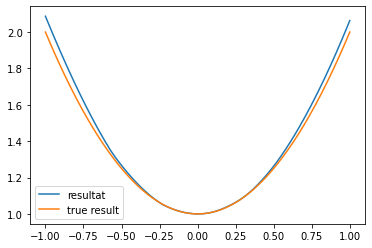

In [19]:
# True Solution (found analitically)
def true_solution(x):
  return x**2 + 1

X = tf.constant(np.linspace(-1, 1, 200),dtype='float32')
result = []
for x in X:
  # print(g(tf.reshape(x,[1])).numpy()[0])
  result.append(g(tf.reshape(x,[1])).numpy()[0])

S = true_solution(X)

plt.plot(X, result, label='resultat')
plt.plot(X, S, label='true result')
plt.legend()
plt.show()

# Questions 

Quelle architecture ? 

Comment éviter l'overfitting ?

Comment exploiter les avantages de l'IA ?

Choix de l'optimizer + regularizer ? + Implémentation ?

Implémentation de système d'EDP à plusieurs inconnues (étant des fonctions bien sûr) ?

Plus rapide ? Comment enlever les boucles `for` ? => batch_gradient_descent ?

Besoin de batch_normalization ? + autres hyperparamètres ?

# Idées

Ajout de bruit en entrée contre l'overfitting 

Une sortie par inconnue